# Solving Ordinary Differential Equations with Neural Networks

*Based on the paper [Artificial Neural Networks for Solving Ordinary and Partial Differential Equations by I. E. Lagaris, A. Likas and D. I. Fotiadis(1997)](https://arxiv.org/abs/physics/9705023)*

## Problem 04

**Problem:** Find solution of 
\begin{align*}
\begin{cases}
    \nabla^2 u_N(x,y) &= e^{-x}(x-2+y^3+6y) \\
    u(0,y) &= y^3 \\
    u(1,y) &= (1+y^3)e^{-1} \\
    u(x,0) &= xe^{-x} \\
    u(y,1) &= e^{-x}(x+1)
\end{cases}
\end{align*}

on the interval $(x,y) \in [0,1]^2$. 

## Notation

$u_N$ denotes the **trial solution** of a neural network, that we will train in the following.

$u_a$ denotes the **analytic solution** or the *target function* of the ODE above. This is what our neural network should learn. The exact analytic solution of the ODE above reads 

$$
    u_a(x) = e^{-x}(x+y^3) \tag{1}.
$$

## Key Idea

Write 

$$u_N(x) = A(x,y) + x(1-x)y(1-y)N_p(x,y),$$

where $N(x,p)$ is the neural network with training parameter $p$. What is $A$? This term should satisfy the constraints imposed by the Dirichlet condition. Look at

\begin{align*}
    A(x,y) = (1-x)y^3 + x(1+y^3)e^{-1} + (1-y)x(e^{-x} - e^{-1}) + y\left((1+x)e^{-x} - (1-x+2xe^{-1})\right)
\end{align*}

This ansatz satisfies the Dirichlet conditions. It just remains to adjust the parameter $p$ such that $u_N(x)$ approximates the target function $u_a$ for any $(x,y) \in [0,1]^2$ very well.

## Architecture of the Neural Network

We use a neural network with **one hidden layer** containing **$H=10$ neurons** and the **sigmoid function** as the activation function. The neural network has one single input layer and a single linear output layer.

## Training the Neural Network

Discretize $[0,1]^2$ such that we have a grid of $100$ equidistant points $x_1,...,x_{100} \in [0,1]^2$. Define the **loss function** as

$$
    E = \sum_{i=1}^{10} \left(\frac{d^2}{dx^2}u_N(x_i) + \frac{d^2}{dy^2}u_N(x_i) - f(x_i, u_N(x_i))\right)^2,
$$

where $f$ is the right hand side of the PDE.

In [0]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time 

In [0]:
DOMAIN = [[0.0, 1.0], [0.0, 1.0]]
WIDTH = 10 # number of neurons in the hidden layer
NUM_TRAINING_POINTS = 10
INPUT_DIMENSION = 1

xs = np.linspace(DOMAIN[0][0], DOMAIN[0][1], NUM_TRAINING_POINTS)
ys = np.linspace(DOMAIN[1][0], DOMAIN[1][1], NUM_TRAINING_POINTS)

#xx = np.linspace(0.2,0.6, 100)
#yy = np.linspace(0.5,0.8, 100)

def target_func(x, y):
    return np.exp(-x)*(x+y**3)

In [0]:
initializer = tf.contrib.layers.xavier_initializer()
#------- Neural network N -------------------------
# Input layer
inputx = tf.placeholder(dtype=tf.float32, shape=(None, INPUT_DIMENSION, ), name="inputx")
inputy = tf.placeholder(dtype=tf.float32, shape=(None, INPUT_DIMENSION, ), name="inputy")
batch_size = tf.shape(inputx)[0]
# Hidden layer
WX = tf.Variable(initializer((WIDTH, INPUT_DIMENSION)), dtype=tf.float32, name="WX") # input layer for x axis 
WY = tf.Variable(initializer((WIDTH, INPUT_DIMENSION)), dtype=tf.float32, name="WY") # input layer for y axis 
b = tf.Variable(initializer((WIDTH,)), dtype=tf.float32, name="b1") # Bias

zx = tf.matmul(tf.broadcast_to(WX, [batch_size,WIDTH,INPUT_DIMENSION] ), tf.reshape(inputx, shape=[-1, INPUT_DIMENSION, 1]))
zy = tf.matmul(tf.broadcast_to(WY, [batch_size,WIDTH,INPUT_DIMENSION] ), tf.reshape(inputy, shape=[-1, INPUT_DIMENSION, 1]))
z = tf.add(tf.add(zx, zy), tf.reshape(b, shape=(WIDTH, 1)))
sigmoid_z = tf.nn.sigmoid(z)

# Single Output layer
v = tf.Variable(initializer((1,WIDTH)), dtype=tf.float32, name="v") # Weights output layer
output = tf.reshape(tf.matmul(tf.broadcast_to(v,[batch_size,1,WIDTH]), sigmoid_z), [-1,1,])

In [0]:
#-------  u_xx ------------
vWx = tf.multiply(tf.reshape(WX, [WIDTH]), v)
sigmdx = tf.multiply(tf.sigmoid(z), (1-tf.sigmoid(z)))
prodx = tf.multiply(tf.reshape(vWx, shape = (1, -1, 1)), sigmdx)
dNx = tf.reduce_sum(prodx, axis = 1) # first derivative of N towards x
#dNx = tf.gradients([output], [inputx]) 

Wxx = tf.square(WX)
vWxx = tf.multiply(tf.reshape(Wxx, [WIDTH]), v)
sigmdxx = tf.multiply( tf.multiply(tf.sigmoid(z), (1-tf.sigmoid(z))), (1- 2 *tf.sigmoid(z)))
prodxx = tf.multiply(tf.reshape(vWxx, shape = (1, -1, 1)), sigmdxx)
dNxx = tf.reduce_sum(prodxx, axis = 1)# second derivative of N towards y 
#dNxx = tf.gradients([dNx], [inputx])

Axx = tf.multiply(tf.exp(-inputx), (tf.add(tf.add(inputx, inputy),-2)))
uxx = tf.add(Axx, inputy * (1- inputy)* (dNxx* inputx *(1- inputx) + 2* dNx * (1- 2* inputx)- 2 * output))

#------------ u_yy-----------

vWy = tf.multiply(tf.reshape(WY, [WIDTH]), v)
sigmdy = tf.multiply(tf.sigmoid(z), (1-tf.sigmoid(z)))
prody = tf.multiply(tf.reshape(vWy, shape = (1, -1, 1)), sigmdy)
dNy = tf.reduce_sum(prody, axis = 1) # first derivative of N towards y
#dNy = tf.gradients([output], [inputy]) 

Wyy = tf.square(WY)
vWyy = tf.multiply(tf.reshape(Wyy, [WIDTH]), v)
sigmdyy = tf.multiply( tf.multiply(tf.sigmoid(z), (1-tf.sigmoid(z))), (1- 2 *tf.sigmoid(z)))
prodyy = tf.multiply(tf.reshape(vWyy, shape = (1, -1, 1)), sigmdyy)
dNyy = tf.reduce_sum(prodyy, axis = 1)# second derivative of N towards y 
#dNyy = tf.gradients([dNy], [inputy]) 

Ayy = (- tf.exp(1.0) * inputx + inputx + tf.exp(1.0))* inputy * 6/ tf.exp(1.0)

uyy = Ayy + inputx * (1- inputx) * (dNyy * inputy*(1- inputy) + 2* dNy* (1-2* inputy)- 2* output )


#-----------trial solution -------------------
A = (1-inputx)*inputy**3 + inputx*(1+inputy**3)/tf.exp(1.0) + (1-inputy)*inputx*(1/tf.exp(inputx) - 1/tf.exp(1.0)) + inputy * ((1+inputx)/tf.exp(inputx) - (1-inputx+2*inputx/tf.exp(1.0)))
u = A + inputx * (1- inputx) *inputy *(1-inputy)* output
f = tf.exp(-1.0)* (inputx - 2 + inputy**3+ 6 * inputy)

loss = tf.reduce_sum(tf.square(uxx+ uyy- f))

#ttarget = tf.exp(-inputx)*(inputx + inputy**3)
#loss = tf.reduce_sum(tf.square(u - ttarget))

Start training...
Elapsed time: 1.60104
Relative Error: 0.11884


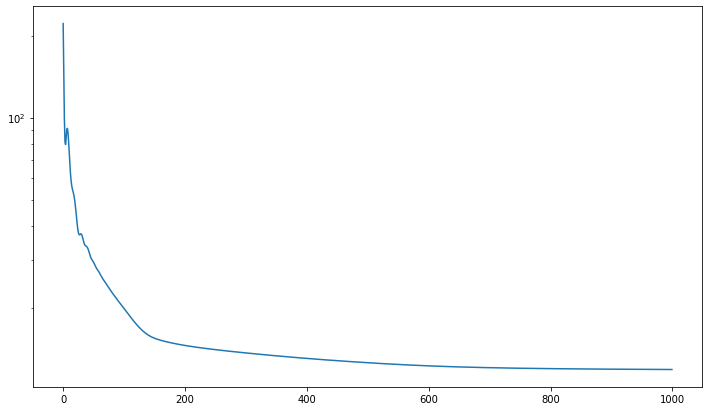

In [0]:
INIT_L_RATE = 0.1
FINAL_L_RATE = 1e-5
NUM_ITER = 1000

global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(
    INIT_L_RATE,
    global_step,
    1,
    np.exp(np.log(FINAL_L_RATE/INIT_L_RATE) / NUM_ITER),
    staircase=True
)
step = tf.train.AdamOptimizer(0.1).minimize(loss, global_step=global_step)

session = tf.Session()
session.run(tf.global_variables_initializer())

ERROR_RATE = []
HISTORY = []

X,Y = np.meshgrid(xs, ys)
XX, YY = np.meshgrid(xx, yy)

prediction = np.reshape(session.run(u,feed_dict={inputx: np.reshape(np.ravel(X), (-1,1)), 
                                                 inputy: np.reshape(np.ravel(Y), (-1,1))}), (-1,))
prediction = np.array(prediction).reshape(X.shape)
HISTORY.append(prediction)

t0 = time.time()
print("Start training...")
for i in range(NUM_ITER):
    loss_val, _  = session.run(
        [loss, step],
        feed_dict={inputx: np.reshape(np.ravel(X), (-1,1)), inputy: np.reshape(np.ravel(Y), (-1,1))}    )
    ERROR_RATE.append(loss_val)
    
    # save the graph of u_N after each iteration
    # later used to construct an animated gif 
    # that shows the convergence of u_N
    if (i % 5 == 0 and i<= 300):
        prediction = np.reshape(session.run(u,feed_dict={inputx: np.reshape(np.ravel(X), (-1,1)), 
                                                 inputy: np.reshape(np.ravel(Y), (-1,1))}), (-1,))
        prediction = np.array(prediction).reshape(X.shape)
        HISTORY.append(prediction)

plt.figure(figsize = (12,7))
plt.plot(ERROR_RATE)
plt.yscale("log")

print("Elapsed time: {:0.5f}".format(time.time() - t0))
print("Relative Error: {:0.5f}".format(ERROR_RATE[-1] / NUM_TRAINING_POINTS**2))

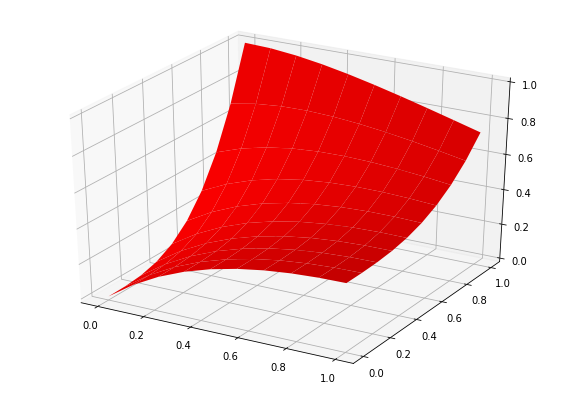

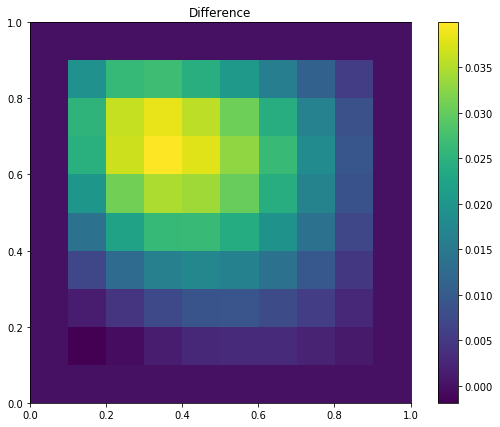

In [0]:
RESOLUTION = 200
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Xaxis = np.linspace(0.5, 0.5, RESOLUTION)
Yaxis = np.linspace(0.5, 0.6, RESOLUTION)
Xaxis, Yaxis = np.meshgrid(xs, ys)

target = target_func(np.ravel(Xaxis), np.ravel(Yaxis))
prediction = np.reshape(session.run(u,feed_dict={inputx: np.reshape(np.ravel(Xaxis), (-1,1)), 
                                                 inputy: np.reshape(np.ravel(Yaxis), (-1,1))}), (-1,))

prediction = np.array(prediction).reshape(Xaxis.shape)
target = np.array(target).reshape(Xaxis.shape)

# Plot both solutions
fig = plt.figure(0,figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
#ax.plot_surface(Xaxis, Yaxis, prediction, label="$u(x) = A(x,y)+ x(1-x) y(1-y) N_p(x,y)$")
ax.plot_surface(Xaxis, Yaxis, target, label="$f(x) = e^{-x}(x+y^3)$", color='r')

# Plot the difference
fig = plt.figure(1,figsize=(10,7))
plt.imshow(prediction-target, extent=[0.0, 1.0, 0.0, 1.0], origin='lower')
plt.title('Difference')
plt.colorbar()

# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(Xaxis, Yaxis, prediction-target, label="prediction-target")

In [0]:
RESOLUTION = 200
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Xaxis = np.linspace(0, 1, 200)
Yaxis = np.linspace(0, 1, 200)
Xaxis, Yaxis = np.meshgrid(Xaxis, Yaxis)

target = target_func(np.ravel(Xaxis), np.ravel(Yaxis))
target = np.array(target).reshape(Xaxis.shape)

i = 0
for ys in HISTORY:
    fig = plt.figure(i,figsize=(10,7),dpi=300)
    plt.imshow(prediction-target, extent=[0.0, 1.0, 0.0, 1.0], origin='lower')
    plt.title('Difference')
    plt.colorbar()
    plt.savefig('{}.png'.format(i))
    plt.close(fig)
    i = i + 1